### Análise da qualidade da água para o consumo humano
#### Base de dados: <https://www.kaggle.com/datasets/adityakadiwal/water-potability>

Aluno: Vinícius de Souza Dias Carneiro

#### Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

#### Exploração dos dados

In [2]:
data = pd.read_csv('water_potability.csv')

In [3]:
data.shape

(3276, 10)

In [4]:
data.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [5]:
data.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [7]:
# Quantidade de valores ausentes por atributo
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [8]:
# Percentual de valores ausentes por atributo
data.isnull().mean().round(4) * 100

ph                 14.99
Hardness            0.00
Solids              0.00
Chloramines         0.00
Sulfate            23.84
Conductivity        0.00
Organic_carbon      0.00
Trihalomethanes     4.95
Turbidity           0.00
Potability          0.00
dtype: float64

In [9]:
# Quantidade de instâncias por classe (0 = não potável e 1 = potável)
classes = data['Potability'].value_counts()
classes

0    1998
1    1278
Name: Potability, dtype: int64

In [10]:
# Verificar desbalanceamento de classe

'''
Se a classe minoritária possuir menos de 10% das instâncias
totais, há um desequilíbrio grande no conjunto de dados!!
'''

# Representatividade da classe minoritária
percentage = classes[1] / classes.sum() * 100

if percentage >= 10:
    print(f'{percentage:.2f}% - Desequilíbrio leve')
else:
    print(f'{percentage:.2f}% - Desequilíbrio grande')

39.01% - Desequilíbrio leve


#### Processamento dos dados

In [11]:
# Preencher os valores ausentes com o valor médio do atributo
data['ph'].fillna(data['ph'].mean(), inplace=True)
data['Sulfate'].fillna(data['Sulfate'].mean(), inplace=True)
data['Trihalomethanes'].fillna(data['Trihalomethanes'].mean(), inplace=True)

In [12]:
# Remover outliers que estão a mais de 3 desvios padrão da média
for column in data.columns:
    mean = data[column].mean()
    std = data[column].std()

    data = data[(data[column] <= mean + (3 * std))]

In [13]:
# Separar atributos/classe
attributes = data.drop('Potability', axis=1)
target = data['Potability'].values

In [14]:
attributes # Variáveis quantitativas contínuas

ph    Hardness        Solids  Chloramines     Sulfate  \
0     7.080795  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246  333.775777   
2     8.099124  224.236259  19909.541732     9.275884  333.775777   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  333.775777   
3273  9.419510  175.762646  33155.578218     7.350233  333.775777   
3274  5.126763  230.603758  11983.869376     6.303357  333.775777   
3275  7.874671  195.102299  17404.177061     7.509306  333.775777   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  
0       564.308654       10.379783        86.990970   2.963135  
1       592.885359       15.180013        56.329076   4.500656  
2       418.606213       16.868637        66.420093   3.055934  
3       363.266516       18.436524       100.341674   4.628771  
4       398.410813       11.558279        31.997993   4.075075  
...            ...             ...              ...        ...  
3271    526.424171       13.894419        66.687695   4.435821  
3272    392.449580       19.903225        66.396293   2.798243  
3273    432.044783       11.039070        69.845400   3.298875  
3274    402.883113       11.168946        77.488213   4.708658  
3275    327.459760       16.140368        78.698446   2.309149  

[3180 rows x 9 columns]

In [15]:
target

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
# Oversampling >> sobreamostragem utilizando o SMOTE
smote = SMOTE()
attributes, target = smote.fit_resample(attributes, target)

In [17]:
# Quantidade de instâncias por classe (0 = não potável e 1 = potável)
print(Counter(target))

Counter({0: 1955, 1: 1955})


#### Visualização dos dados

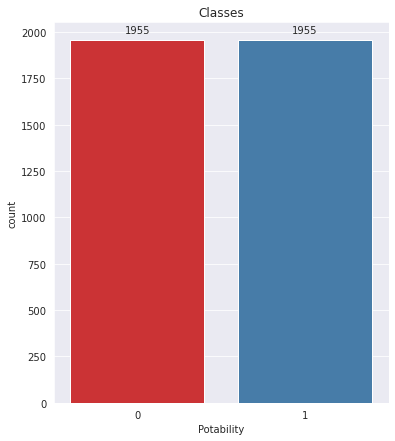

In [18]:
# Mostrar a quantidade de instâncias por classe
plt.figure(figsize=(6, 7))
g1 = sns.countplot(x=target, palette='Set1')
plt.title('Classes')
plt.xlabel('Potability')
for p in g1.patches:
    g1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

Counter({'alkaline': 1846, 'acidic': 1334})


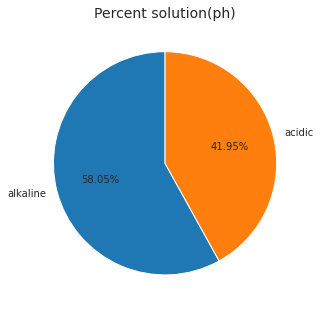

In [19]:
# Função que retorna um array com as soluções(ph) das amostras
def get_solution_ph(arr):
    new_arr = []
    for i in arr:
        if 0 <= i < 7:
            new_arr.append('acidic')
        elif i == 7:
            new_arr.append('neutral')
        elif 7 < i <= 14:
            new_arr.append('alkaline')
    return new_arr

# Mostrar percentual solução(ph)
solution = Counter(get_solution_ph(data['ph'].values))
print(solution)
plt.figure(figsize=(5, 6))
plt.pie(list(solution.values()), labels=list(solution.keys()), startangle=90, autopct='%.2f%%')
plt.title('Percent solution(ph)', fontsize=14);

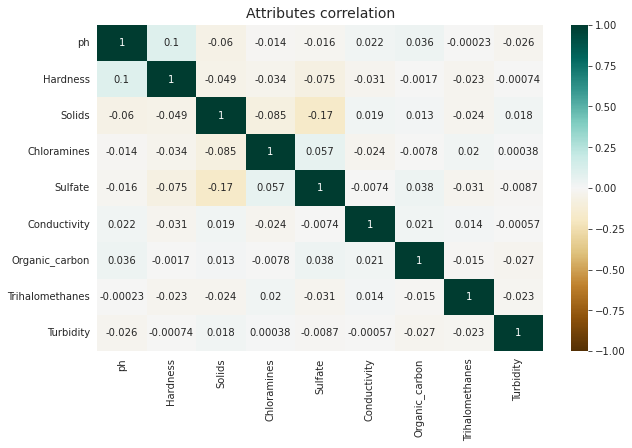

In [20]:
# Analisar a correlação entre os atributos do dataset
plt.figure(figsize=(10, 6))
sns.heatmap(attributes.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Attributes correlation', fontsize=14, pad=7);

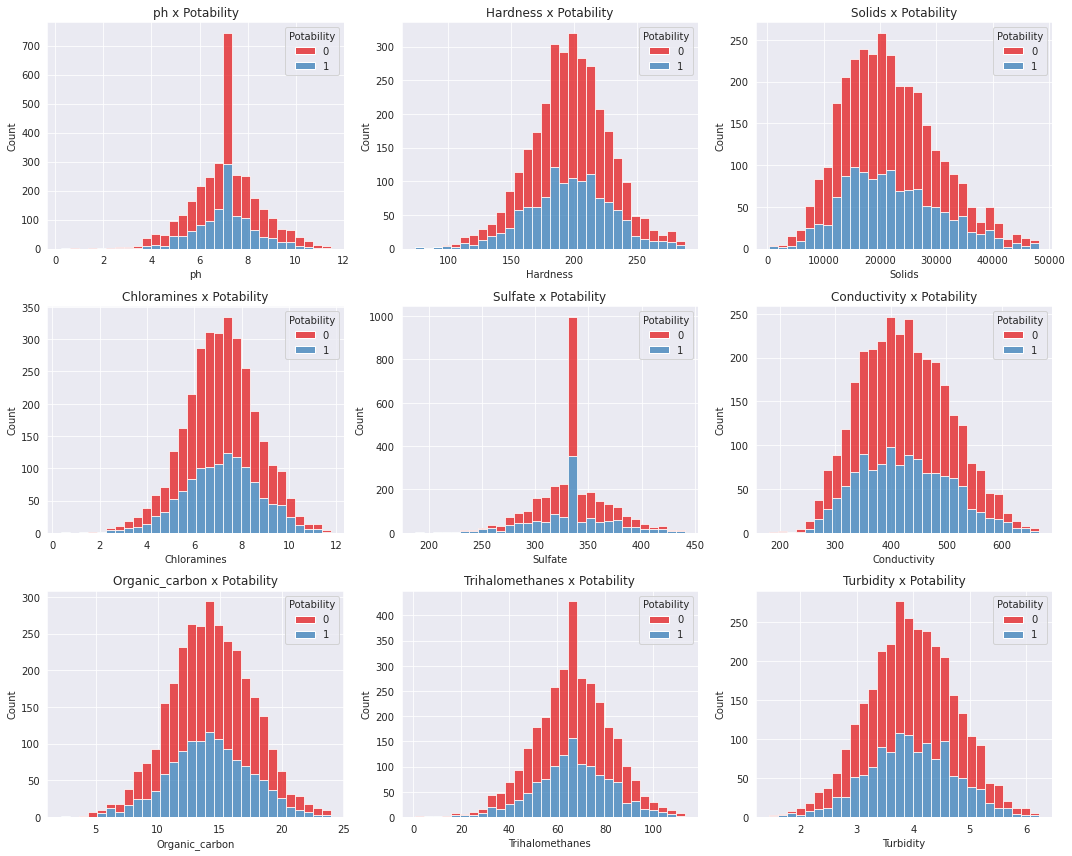

In [21]:
# Função para mostrar a distribuição dos atributos em relação a 'Potability'
def relation_by_potability_histplot(data):
    fig, ax = plt.subplots(3, 3, figsize=(15, 12))
    idx_col = 0
    for i in range(3):
        for j in range(3):
            sns.histplot(x=data.columns[idx_col], data=data, ax=ax[i][j], hue='Potability', multiple='stack', bins=30, palette='Set1')
            ax[i][j].set_title(f'{data.columns[idx_col]} x Potability')
            idx_col += 1
    plt.tight_layout()

relation_by_potability_histplot(data)

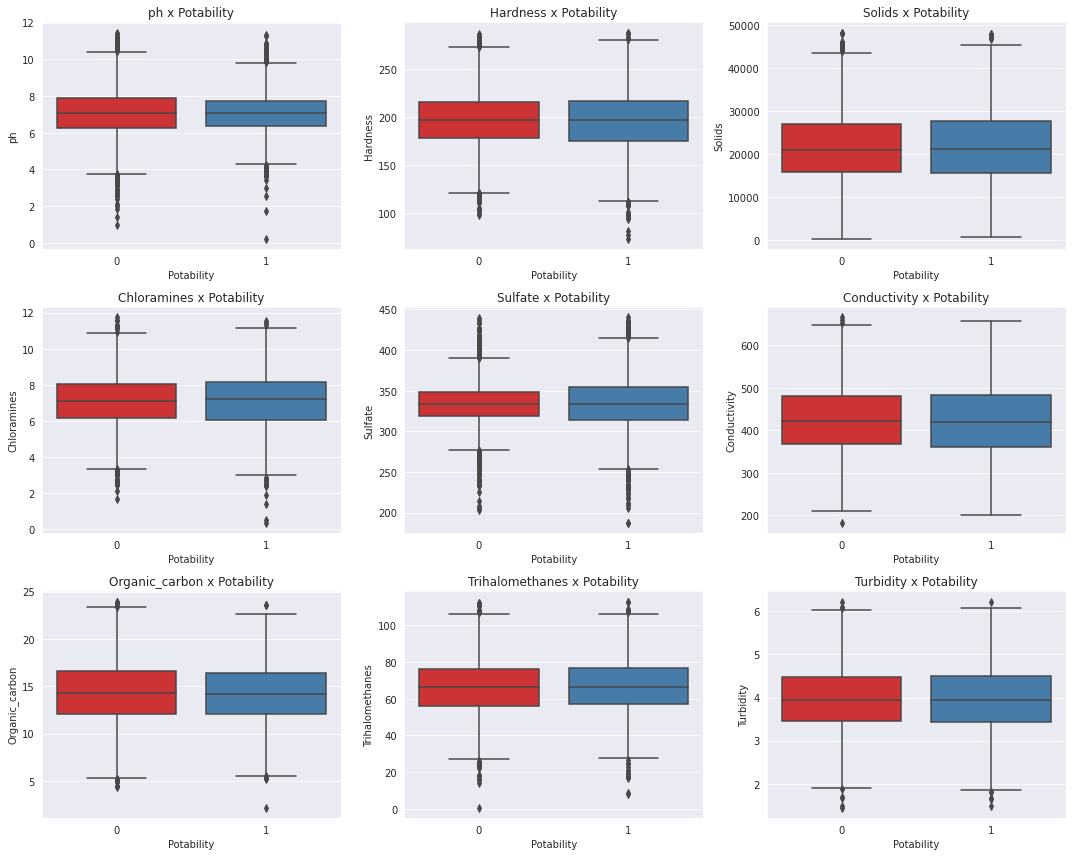

In [22]:
# Função para mostrar a distribuição dos atributos em relação a 'Potability'
def relation_by_potability_boxplot(data):
    fig, ax = plt.subplots(3, 3, figsize=(15, 12))
    idx_col = 0
    for i in range(3):
        for j in range(3):
            sns.boxplot(x=data['Potability'], y=data[data.columns[idx_col]], ax=ax[i][j], palette='Set1')
            ax[i][j].set_title(f'{data.columns[idx_col]} x Potability')
            idx_col += 1
    plt.tight_layout()

relation_by_potability_boxplot(data)

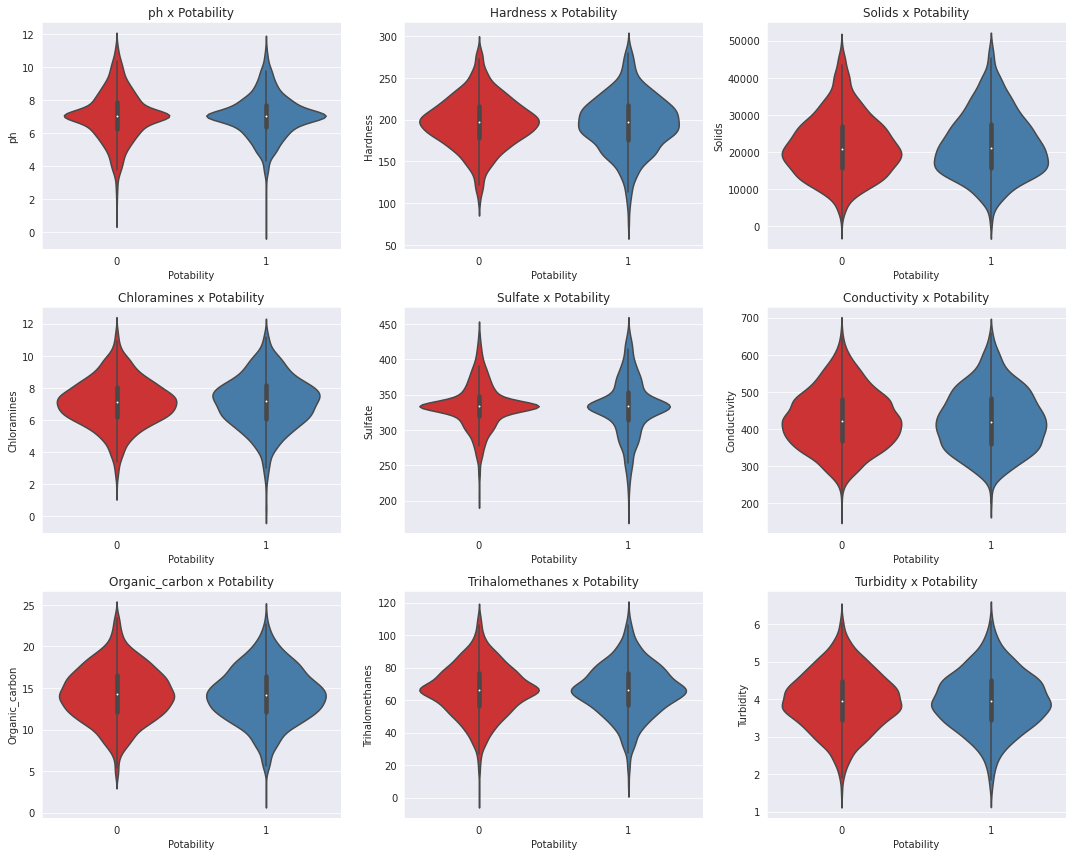

In [23]:
# Função para mostrar a distribuição dos atributos em relação a 'Potability'
def relation_by_potability_violinplot(data):
    fig, ax = plt.subplots(3, 3, figsize=(15, 12))
    idx_col = 0
    for i in range(3):
        for j in range(3):
            sns.violinplot(x=data['Potability'], y=data[data.columns[idx_col]], ax=ax[i][j], palette='Set1')
            ax[i][j].set_title(f'{data.columns[idx_col]} x Potability')
            idx_col += 1
    plt.tight_layout()

relation_by_potability_violinplot(data)

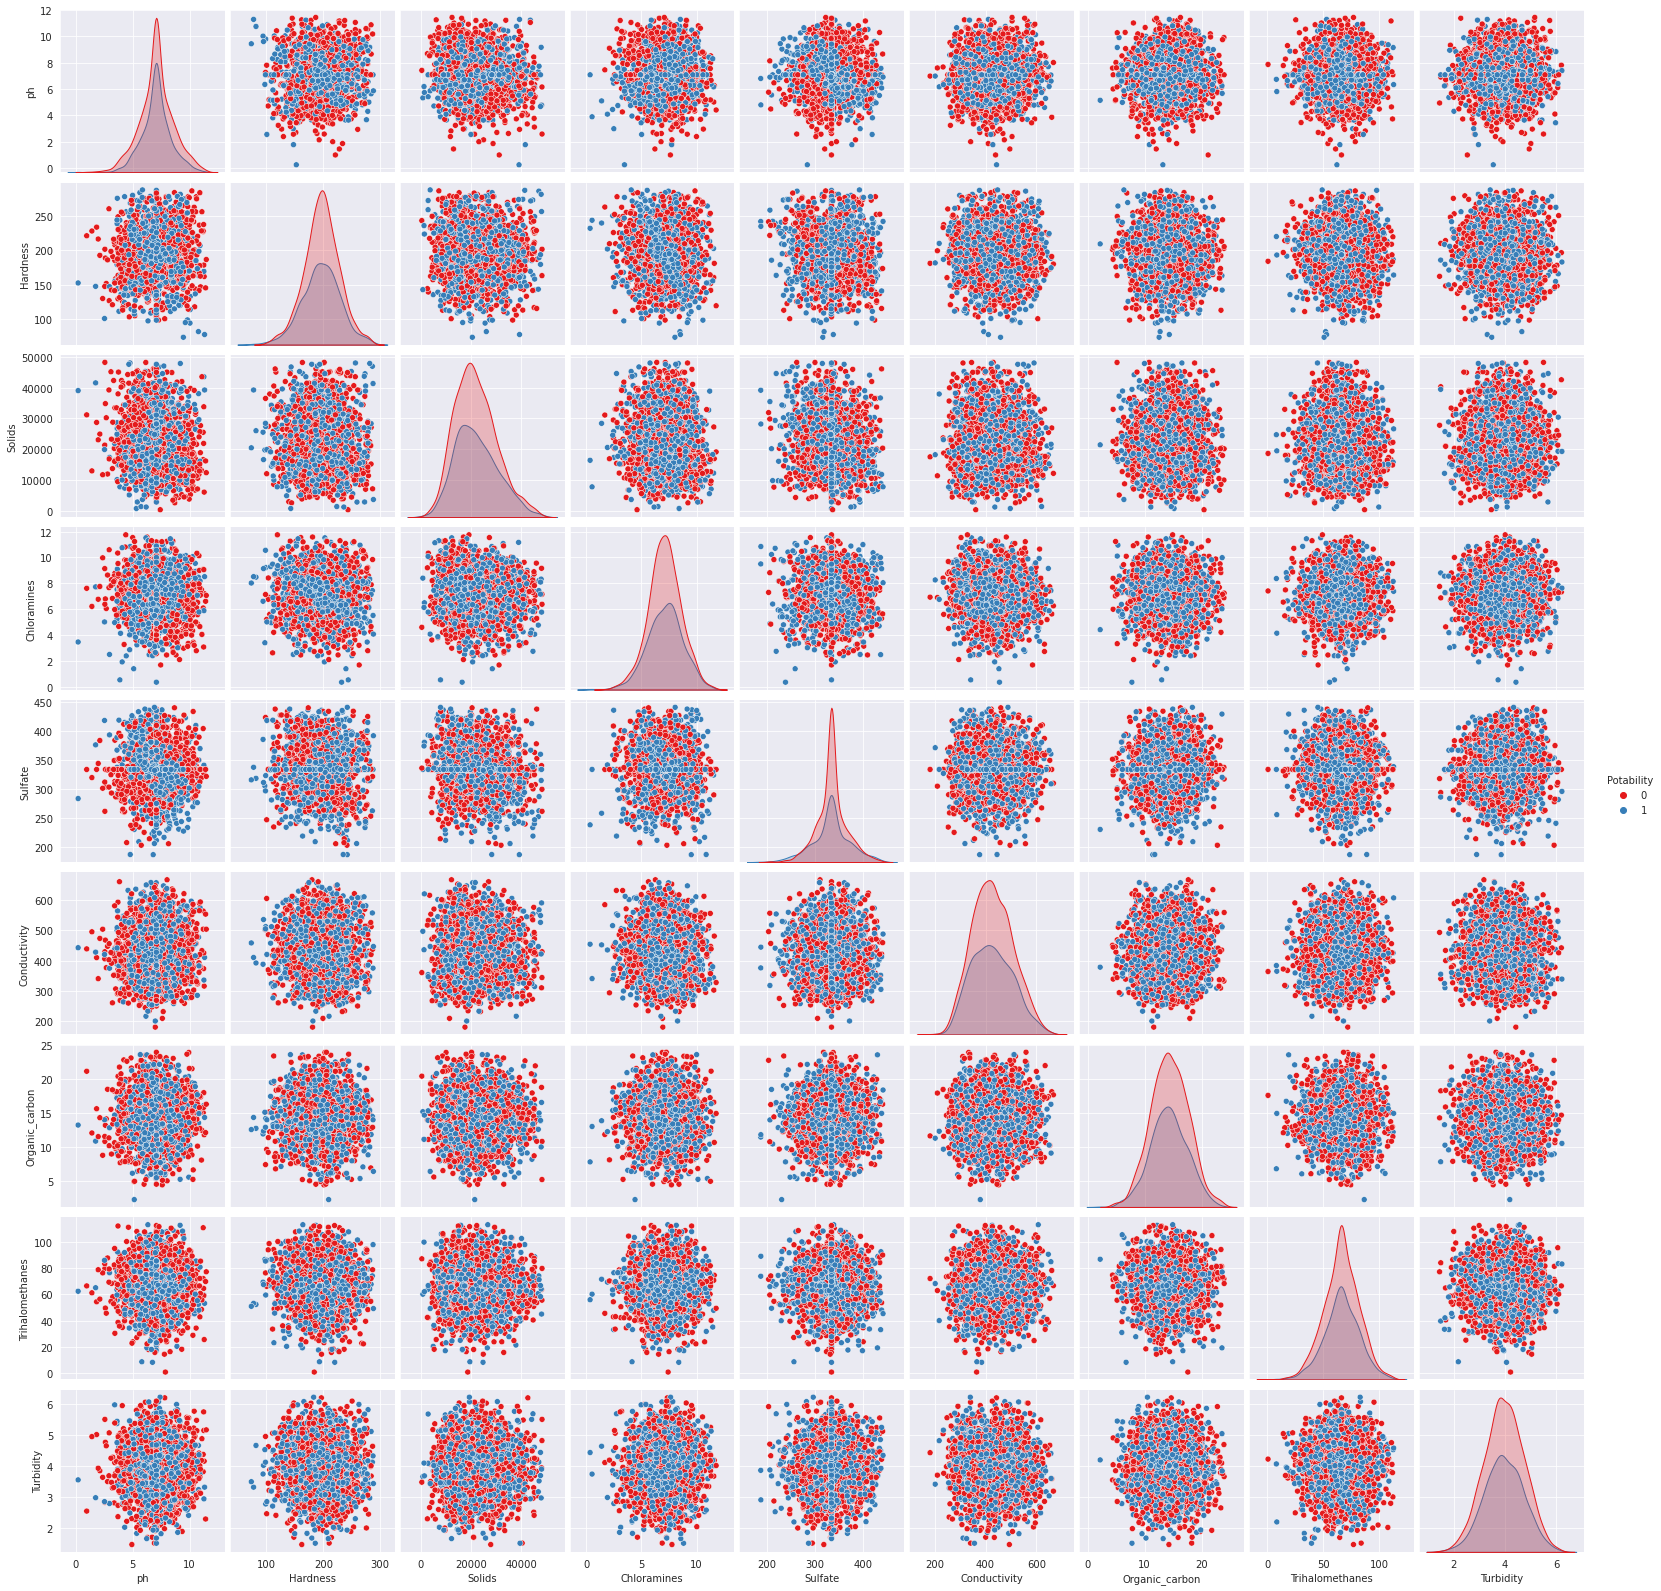

In [24]:
# Função para mostrar o relacionamento de pares de atributos do dataset
sns.pairplot(data, hue='Potability', palette='Set1');

#### Divisão dos dados em dados de treinamento, teste e validação.

In [25]:
# Treinamento/Teste
X_train, X_test, y_train, y_test = train_test_split(attributes, target, test_size=0.2)

# Teste/Validação
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [26]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (3128, 9)
X_test shape: (391, 9)
X_val shape: (391, 9)


#### Padronização dos dados

In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#### Aplicação dos modelos

In [ ]:
# Função para verificar se o modelo sofreu com overfitting ou underfitting
def check_adjust(model, set_type):
    score_train = round(model.score(X_train, y_train, 4)
    print(f'Pontuação do conjunto de treinamento: {score_train}')
                        
    if set_type == 'val':
        score_val = round(model.score(X_val, y_val, 4)
        print(f'Pontuação do conjunto de validação: {score_val}')
    else:
        score_test = round(model.score(X_test, y_test, 4)
        print(f'Pontuação do conjunto de teste: {score_test}')

In [28]:
# Função para mostrar a matriz de confusão dos modelos
def plot_confusion_matrix(y):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(y[0], y[1]), annot=True, fmt='d', cbar=False, ax=ax)

    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Actual class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['not potable', 'potable'])
    ax.yaxis.set_ticklabels(['not potable', 'potable'])
    plt.plot();

In [29]:
# Função para mostrar as métricas de avaliação dos modelos
# Método de avaliação: funções métricas
def evaluate_metrics(y):   
    # precision score
    print(f'Model precision score: {precision_score(y[0], y[1]):.2f}')
    print('_' * 54)
    
    # classification report
    print('\nModel classification report:\n\n', classification_report(y[0], y[1]))

In [30]:
# Função que busca os melhores valores de parâmetros para um estimador
# Método de avaliação: parâmetro de pontuação
def search_best_estimator(estimator, param_grid):
    # Instanciar objeto do GridSearchCV
    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, refit=True, cv=10)
    
    # Ajustar o classificador utilizando GridSearchCV ao conjunto de treinamento
    grid.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    grid_predictions = grid.predict(X_test)

    # Mostrar parâmetros que dão os melhores resultados
    print(f'GridSearchCV best params: {grid.best_params_}')
    # Mostrar estimador escolhido pelo GridSearchCV
    print(f'GridSearchCV best estimator: {grid.best_estimator_}')
    
    return grid.best_estimator_, grid_predictions

In [31]:
# Lista para guardar a precisão dos modelos
lst_prec_models = []

#### Decision Tree

In [32]:
# Instanciar classificador com hiperparâmetros padrões
# parâmetros: criterion='gini', splitter='best', max_depth=None
clf = DecisionTreeClassifier()

# Ajustar o classificador ao conjunto de treinamento
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de validação
y_pred = clf.predict(X_val)

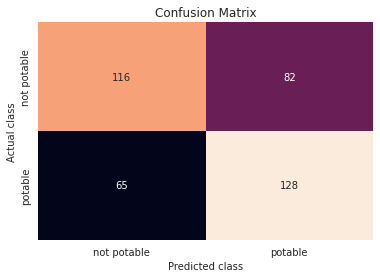

In [33]:
plot_confusion_matrix((y_val, y_pred))

In [34]:
evaluate_metrics((y_val, y_pred))

Model precision score: 0.61
______________________________________________________

Model classification report:

               precision    recall  f1-score   support

           0       0.64      0.59      0.61       198
           1       0.61      0.66      0.64       193

    accuracy                           0.62       391
   macro avg       0.63      0.62      0.62       391
weighted avg       0.63      0.62      0.62       391



In [35]:
# Grade de parâmetros a ser explorada para ajustes de hiperparâmetros
param_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': list(range(1, 21))}
# Ajustes de hiperparâmetros do Decision Tree usando GridSearchCV
DTC_best_estimator, grid_predictions = search_best_estimator(DecisionTreeClassifier(), param_grid)

GridSearchCV best params: {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}
GridSearchCV best estimator: DecisionTreeClassifier(max_depth=7)


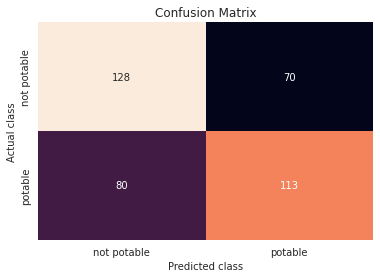

In [36]:
plot_confusion_matrix((y_test, grid_predictions))

In [37]:
evaluate_metrics((y_test, grid_predictions))

Model precision score: 0.62
______________________________________________________

Model classification report:

               precision    recall  f1-score   support

           0       0.62      0.65      0.63       198
           1       0.62      0.59      0.60       193

    accuracy                           0.62       391
   macro avg       0.62      0.62      0.62       391
weighted avg       0.62      0.62      0.62       391



In [38]:
lst_prec_models.append((round(precision_score(y_val, y_pred), 2), round(precision_score(y_test, grid_predictions), 2)))

#### K-Nearest Neighbors

In [39]:
# Instanciar classificador com hiperparâmetros padrões
# parâmetros: n_neighbors=5, weights='uniform', metric='minkowski'
clf = KNeighborsClassifier()

# Ajustar o classificador ao conjunto de treinamento
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de validação
y_pred = clf.predict(X_val)

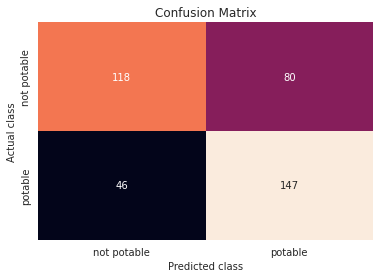

In [40]:
plot_confusion_matrix((y_val, y_pred))

In [41]:
evaluate_metrics((y_val, y_pred))

Model precision score: 0.65
______________________________________________________

Model classification report:

               precision    recall  f1-score   support

           0       0.72      0.60      0.65       198
           1       0.65      0.76      0.70       193

    accuracy                           0.68       391
   macro avg       0.68      0.68      0.68       391
weighted avg       0.68      0.68      0.68       391



In [42]:
# Grade de parâmetros a ser explorada para ajustes de hiperparâmetros
param_grid = {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance']}
# Ajustes de hiperparâmetros do K-Nearest Neighbors usando GridSearchCV
KNN_best_estimator, grid_predictions = search_best_estimator(KNeighborsClassifier(), param_grid)

GridSearchCV best params: {'n_neighbors': 4, 'weights': 'distance'}
GridSearchCV best estimator: KNeighborsClassifier(n_neighbors=4, weights='distance')


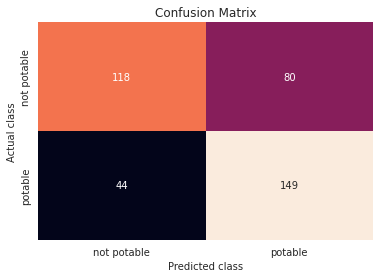

In [43]:
plot_confusion_matrix((y_test, grid_predictions))

In [44]:
evaluate_metrics((y_test, grid_predictions))

Model precision score: 0.65
______________________________________________________

Model classification report:

               precision    recall  f1-score   support

           0       0.73      0.60      0.66       198
           1       0.65      0.77      0.71       193

    accuracy                           0.68       391
   macro avg       0.69      0.68      0.68       391
weighted avg       0.69      0.68      0.68       391



In [45]:
lst_prec_models.append((round(precision_score(y_val, y_pred), 2), round(precision_score(y_test, grid_predictions), 2)))

#### Support Vector Machine

In [46]:
# Instanciar classificador com hiperparâmetros padrões
# parâmetros: C=1.0, kernel='rbf', gamma='scale'
clf=SVC()

# Ajustar o classificador ao conjunto de treinamento
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de validação
y_pred = clf.predict(X_val)

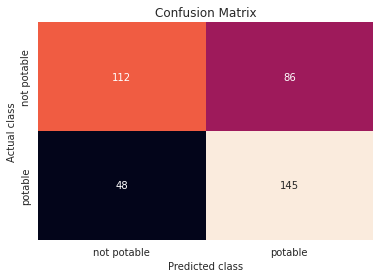

In [47]:
plot_confusion_matrix((y_val, y_pred))

In [48]:
evaluate_metrics((y_val, y_pred))

Model precision score: 0.63
______________________________________________________

Model classification report:

               precision    recall  f1-score   support

           0       0.70      0.57      0.63       198
           1       0.63      0.75      0.68       193

    accuracy                           0.66       391
   macro avg       0.66      0.66      0.65       391
weighted avg       0.66      0.66      0.65       391



In [49]:
# Grade de parâmetros a ser explorada para ajustes de hiperparâmetros
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
# Ajustes de hiperparâmetros do Support Vector Machine usando GridSearchCV
SVC_best_estimator, grid_predictions = search_best_estimator(SVC(), param_grid)

GridSearchCV best params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
GridSearchCV best estimator: SVC(C=1, gamma=1)


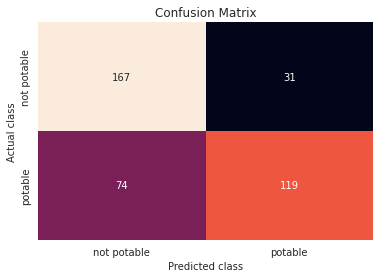

In [50]:
plot_confusion_matrix((y_test, grid_predictions))

In [51]:
evaluate_metrics((y_test, grid_predictions))

Model precision score: 0.79
______________________________________________________

Model classification report:

               precision    recall  f1-score   support

           0       0.69      0.84      0.76       198
           1       0.79      0.62      0.69       193

    accuracy                           0.73       391
   macro avg       0.74      0.73      0.73       391
weighted avg       0.74      0.73      0.73       391



In [52]:
lst_prec_models.append((round(precision_score(y_val, y_pred), 2), round(precision_score(y_test, grid_predictions), 2)))

In [53]:
# Comparação dos modelos
index = ['Decision Tree', 'K-Nearest Neighbors', 'Support Vector Machine']

pd.DataFrame(lst_prec_models, index, columns=['Precision', 'Precision (GridSearchCV)'])

Precision  Precision (GridSearchCV)
Decision Tree                0.61                      0.62
K-Nearest Neighbors          0.65                      0.65
Support Vector Machine       0.63                      0.79

In [54]:
# X e y iniciais
X = scaler.fit_transform(attributes)
y = target

In [55]:
# Função para mostrar a curva de aprendizado do modelo
def plot_learning_curve(model_name, estimator, X, y):
    # Obter tamanhos de treinamento e pontuações de treinamento e teste
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=10, scoring='precision', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
    
    # Calcular média e desvio padrão
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Criar curvas
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Precision')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='Validation Precision')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model precision')
    plt.legend();

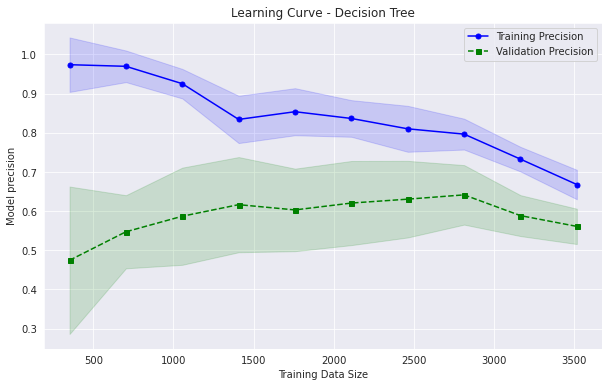

In [56]:
plot_learning_curve('Decision Tree', DTC_best_estimator, X, y)

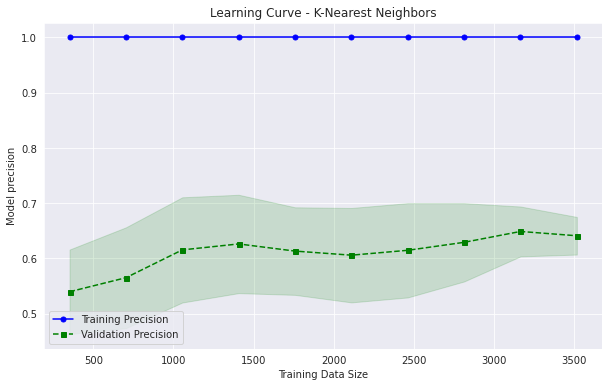

In [57]:
plot_learning_curve('K-Nearest Neighbors', KNN_best_estimator, X, y)

/home/viniciuscarneiro/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/viniciuscarneiro/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/viniciuscarneiro/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/viniciuscarneiro/.local/lib/python3.9/site-packages/sklearn/metrics

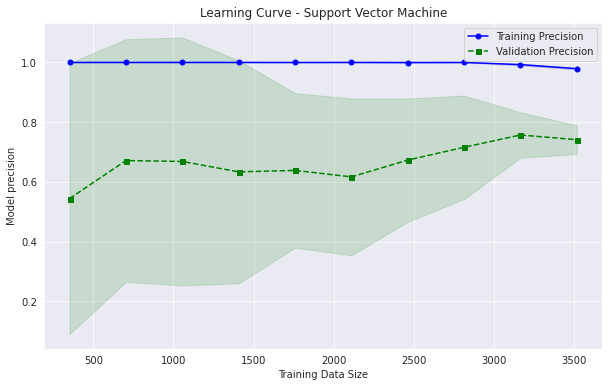

In [58]:
plot_learning_curve('Support Vector Machine', SVC_best_estimator, X, y)

#### Validação cruzada

In [59]:
clfs = [('Decision Tree', DTC_best_estimator),
        ('K-Nearest Neighbors', KNN_best_estimator),
        ('Support Vector Machine', SVC_best_estimator)]

clf_prec_stratified = {}

for clf_name, clf in clfs:
    scores = cross_val_score(clf, X, y, scoring='precision', cv=10)
    clf_prec_stratified[clf_name] = scores

In [60]:
# Função para calcular resultados dos splits (StratifiedKFold)
def get_model_result(lst_precision):
    return [min(lst_precision), max(lst_precision), np.mean(lst_precision), np.std(lst_precision)]

In [61]:
# Criar DataFrame com o resultados dos modelos
data = [get_model_result(clf_prec_stratified['Decision Tree']), 
        get_model_result(clf_prec_stratified['K-Nearest Neighbors']), 
        get_model_result(clf_prec_stratified['Support Vector Machine'])]
index = ['Decision Tree', 'K-Nearest Neighbors', 'Support Vector Machine']
columns = ['Minimum Precision', 
           'Maximum Precision', 
           'Overall Precision',
           'Standard Deviation']

df_result = pd.DataFrame(data, index, columns)
df_result.style.apply(lambda cell: ['background-color: coral' for i in cell], axis=0, subset=['Overall Precision'])

In [62]:
# Função para mostrar a precisão dos splits por modelo
def plot_result_splits(lst_result):
    plt.figure(figsize=(10, 6))
    plt.plot(lst_result['Decision Tree'], color='blue', marker='o', label='Decision Tree')
    plt.plot(lst_result['K-Nearest Neighbors'], color='orange', marker='s', label='K-Nearest Neighbors')
    plt.plot(lst_result['Support Vector Machine'], color='green', marker='D', label='Support Vector Machine')
    plt.title(f'Precision of splits')
    plt.xlabel('Split')
    plt.ylabel('Precision')
    plt.xticks(np.arange(10))
    plt.legend();

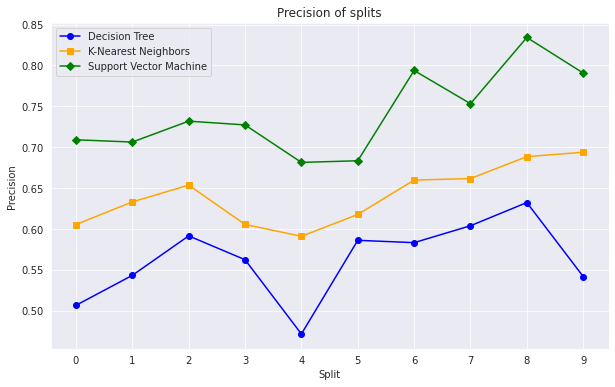

In [63]:
plot_result_splits(clf_prec_stratified)